In [4]:
# 📦 Gerekli Kütüphanelerin Import Edilmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('dark_background')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🎯 Kütüphaneler başarıyla yüklendi!")
print("📊 Matplotlib, Seaborn, Plotly hazır")
print("🤖 Scikit-learn hazır")
print("📈 Veri analizi başlayabilir!")


🎯 Kütüphaneler başarıyla yüklendi!
📊 Matplotlib, Seaborn, Plotly hazır
🤖 Scikit-learn hazır
📈 Veri analizi başlayabilir!


In [5]:
# 📊 Radar Verisinin Yüklenmesi ve İlk Analiz

# Sütun isimleri tanımlama
column_names = [
    'sensor_channel',    # R/L (Right/Left)
    'raw_range',         # Ham mesafe (metre)
    'raw_velocity',      # Ham hız (m/s)
    'raw_angle',         # Ham açı (radyan)
    'timestamp',         # Zaman damgası
    'processed_range',   # İşlenmiş mesafe
    'processed_velocity', # İşlenmiş hız
    'processed_angle',   # İşlenmiş açı
    'object_class'       # Obje sınıfı/durum
]

# Veriyi yükleme
print("📁 Radar verisi yükleniyor...")
try:
    df = pd.read_csv('data-1.txt', sep='\t', names=column_names, header=None)
    print(f"✅ Veri başarıyla yüklendi!")
    print(f"📏 Veri boyutu: {df.shape[0]} satır x {df.shape[1]} sütun")
    print(f"💾 Hafıza kullanımı: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except Exception as e:
    print(f"❌ Hata: {e}")

# İlk 5 satır
print("\n🔍 İlk 5 satır:")
df.head()


📁 Radar verisi yükleniyor...
✅ Veri başarıyla yüklendi!
📏 Veri boyutu: 1224 satır x 9 sütun
💾 Hafıza kullanımı: 0.13 MB

🔍 İlk 5 satır:


,sensor_channel,raw_range,raw_velocity,raw_angle,timestamp,processed_range,processed_velocity,processed_angle,object_class
0,R,8.46642,0.028760,-3.040350e+00,1.477010e+15,8.60,0.25000,-3.00029,0.0
1,L,8.44818,0.251553,1.477010e+15,8.450000e+00,0.25,-3.00027,0.00000,NaN
2,R,8.57101,0.028232,-1.052580e-02,1.477010e+15,8.45,0.25000,0.00000,0.0
3,L,8.45582,0.253997,1.477010e+15,8.450000e+00,0.25,0.00000,0.00000,NaN
4,R,8.42927,0.030143,-1.858130e+00,1.477010e+15,8.35,0.25000,-1.81979,0.0


In [6]:
# 🔧 Veri Temizleme ve Preprocessing

print("🧹 Veri temizleme başlıyor...")

# Veri tiplerini kontrol et
print("\n📊 Veri Tipleri:")
print(df.dtypes)

# Eksik veri kontrolü
print(f"\n❌ Eksik veri sayısı:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Timestamp'i datetime'a çevir (mikrosaniye cinsinden Unix timestamp)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='us')
df['time_relative'] = (df['timestamp'] - df['timestamp'].min()) / 1e6  # Saniye cinsinden relatif zaman

# Açıları derece cinsine çevir
df['raw_angle_deg'] = np.degrees(df['raw_angle'])
df['processed_angle_deg'] = np.degrees(df['processed_angle'])

# Sensör kanallarını ayır
right_sensor = df[df['sensor_channel'] == 'R'].copy()
left_sensor = df[df['sensor_channel'] == 'L'].copy()

print(f"\n📡 Sensör Kanalları:")
print(f"   ➡️  Sağ Radar (R): {len(right_sensor)} ölçüm")
print(f"   ⬅️  Sol Radar (L): {len(left_sensor)} ölçüm")

# Temel istatistikler
print(f"\n📈 Temel İstatistikler:")
df.describe()


🧹 Veri temizleme başlıyor...

📊 Veri Tipleri:
sensor_channel         object
raw_range             float64
raw_velocity          float64
raw_angle             float64
timestamp             float64
processed_range       float64
processed_velocity    float64
processed_angle       float64
object_class          float64
dtype: object

❌ Eksik veri sayısı:
object_class    612
dtype: int64

📡 Sensör Kanalları:
   ➡️  Sağ Radar (R): 612 ölçüm
   ⬅️  Sol Radar (L): 612 ölçüm

📈 Temel İstatistikler:


,raw_range,raw_velocity,raw_angle,timestamp,processed_range,processed_velocity,processed_angle,object_class,datetime,time_relative,raw_angle_deg,processed_angle_deg
count,1224.000000,1224.000000,1.224000e+03,1.224000e+03,1224.000000,1224.000000,1224.000000,612.000000,1224,1.224000e+03,1.224000e+03,1224.000000
mean,9.480716,-3.629788,7.385052e+14,7.385052e+14,0.643709,-3.292863,-0.003327,-0.041437,1993-05-27 12:20:37.991035008,7.385052e+08,4.231323e+16,-0.190649
min,4.366910,-13.265400,-4.323220e+00,4.350000e+00,-13.250000,-13.250000,-3.999760,-3.999760,1970-01-01 00:00:00.000004350,0.000000e+00,-2.477023e+02,-229.169367
25%,7.258050,-6.551073,2.312345e-01,7.950000e+00,-6.550000,-6.562500,-1.996668,-2.723960,1970-01-01 00:00:00.000007950,3.600000e-06,1.324876e+01,-114.400621
50%,9.572570,-1.088910,7.385052e+14,7.385052e+14,2.325000,-1.997775,0.908133,0.000000,1993-05-27 12:20:21.699824128,7.385052e+08,4.231323e+16,52.032159
75%,11.129625,-0.554212,1.477010e+15,1.477010e+15,7.900000,0.908319,1.818703,1.820215,2016-10-21 00:41:15.872216832,1.477010e+09,8.462647e+16,104.203977
max,15.901700,0.263752,1.477011e+15,1.477011e+15,11.350000,2.999760,4.003210,4.003200,2016-10-21 00:41:48.654756,1.477011e+09,8.462647e+16,229.367038
std,2.762579,4.277173,7.388071e+14,7.388071e+14,7.998571,4.691421,2.039047,2.235834,NaN,7.388071e+08,4.233053e+16,116.828802


In [7]:
# 📊 Detaylı İstatistiksel Analiz

print("📈 Detaylı istatistiksel analiz başlıyor...\n")

# Sensör kanallarına göre analiz
def analyze_channel(data, channel_name):
    print(f"🎯 {channel_name} Kanalı Analizi:")
    print(f"   📏 Mesafe Aralığı: {data['raw_range'].min():.2f} - {data['raw_range'].max():.2f} metre")
    print(f"   🏃 Hız Aralığı: {data['raw_velocity'].min():.3f} - {data['raw_velocity'].max():.3f} m/s")
    print(f"   🌀 Açı Aralığı: {data['raw_angle_deg'].min():.1f}° - {data['raw_angle_deg'].max():.1f}°")
    print(f"   ⏱️  Toplam Süre: {data['time_relative'].max():.2f} saniye")
    print(f"   📊 Ölçüm Sayısı: {len(data)}")
    print()

analyze_channel(right_sensor, "SAĞ RADAR")
analyze_channel(left_sensor, "SOL RADAR")

# Hız kategorileri
df['velocity_category'] = pd.cut(df['raw_velocity'], 
                               bins=[-np.inf, -0.5, -0.1, 0.1, 0.5, np.inf],
                               labels=['Hızla_Uzaklaşan', 'Yavaş_Uzaklaşan', 'Sabit', 'Yavaş_Yaklaşan', 'Hızla_Yaklaşan'])

print("🚗 Hız Kategorileri Dağılımı:")
velocity_dist = df['velocity_category'].value_counts()
for category, count in velocity_dist.items():
    percentage = (count / len(df)) * 100
    print(f"   {category}: {count} ölçüm ({percentage:.1f}%)")

# Mesafe kategorileri  
df['range_category'] = pd.cut(df['raw_range'], 
                            bins=[0, 5, 10, 15, 20, np.inf],
                            labels=['Çok_Yakın', 'Yakın', 'Orta', 'Uzak', 'Çok_Uzak'])

print(f"\n📏 Mesafe Kategorileri Dağılımı:")
range_dist = df['range_category'].value_counts()
for category, count in range_dist.items():
    percentage = (count / len(df)) * 100
    print(f"   {category}: {count} ölçüm ({percentage:.1f}%)")


📈 Detaylı istatistiksel analiz başlıyor...

🎯 SAĞ RADAR Kanalı Analizi:
   📏 Mesafe Aralığı: 6.28 - 15.90 metre
   🏃 Hız Aralığı: -1.197 - 0.031 m/s
   🌀 Açı Aralığı: -247.7° - 245.7°
   ⏱️  Toplam Süre: 1477010508.65 saniye
   📊 Ölçüm Sayısı: 612

🎯 SOL RADAR Kanalı Analizi:
   📏 Mesafe Aralığı: 4.37 - 11.37 metre
   🏃 Hız Aralığı: -13.265 - 0.264 m/s
   🌀 Açı Aralığı: 84626464706410112.0° - 84626468445537152.0°
   ⏱️  Toplam Süre: 0.00 saniye
   📊 Ölçüm Sayısı: 612

🚗 Hız Kategorileri Dağılımı:
   Hızla_Uzaklaşan: 943 ölçüm (77.0%)
   Yavaş_Uzaklaşan: 144 ölçüm (11.8%)
   Sabit: 103 ölçüm (8.4%)
   Yavaş_Yaklaşan: 34 ölçüm (2.8%)
   Hızla_Yaklaşan: 0 ölçüm (0.0%)

📏 Mesafe Kategorileri Dağılımı:
   Yakın: 671 ölçüm (54.8%)
   Orta: 431 ölçüm (35.2%)
   Uzak: 62 ölçüm (5.1%)
   Çok_Yakın: 60 ölçüm (4.9%)
   Çok_Uzak: 0 ölçüm (0.0%)


🎨 Görselleştirmeler oluşturuluyor...



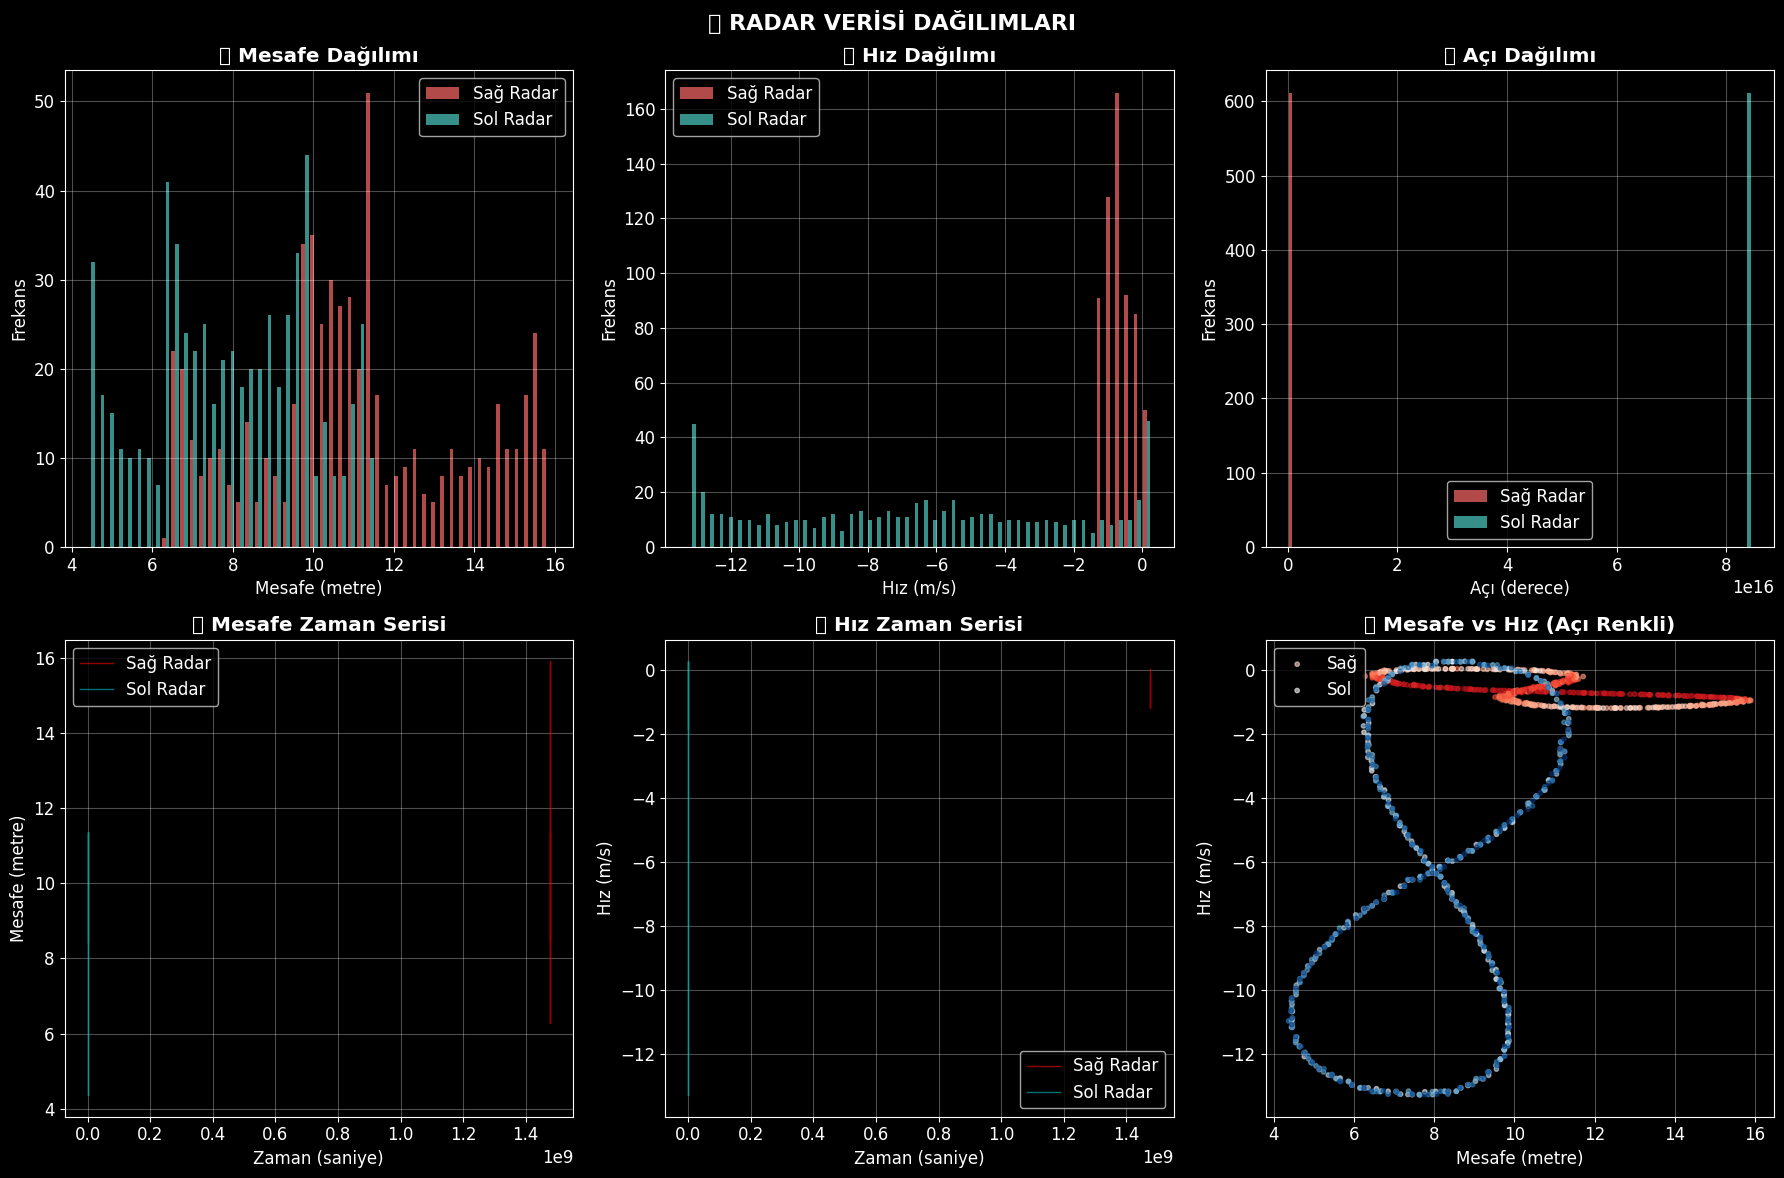

✅ Temel görselleştirmeler tamamlandı!


In [8]:
# 📊 Temel Veri Görselleştirmeleri

print("🎨 Görselleştirmeler oluşturuluyor...\n")

# 1. Mesafe, Hız ve Açı Dağılımları
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🎯 RADAR VERİSİ DAĞILIMLARI', fontsize=16, fontweight='bold', y=0.98)

# Mesafe histogramı
axes[0,0].hist([right_sensor['raw_range'], left_sensor['raw_range']], 
               bins=50, alpha=0.7, label=['Sağ Radar', 'Sol Radar'], color=['#FF6B6B', '#4ECDC4'])
axes[0,0].set_title('📏 Mesafe Dağılımı', fontweight='bold')
axes[0,0].set_xlabel('Mesafe (metre)')
axes[0,0].set_ylabel('Frekans')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Hız histogramı
axes[0,1].hist([right_sensor['raw_velocity'], left_sensor['raw_velocity']], 
               bins=50, alpha=0.7, label=['Sağ Radar', 'Sol Radar'], color=['#FF6B6B', '#4ECDC4'])
axes[0,1].set_title('🏃 Hız Dağılımı', fontweight='bold')
axes[0,1].set_xlabel('Hız (m/s)')
axes[0,1].set_ylabel('Frekans')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Açı histogramı
axes[0,2].hist([right_sensor['raw_angle_deg'], left_sensor['raw_angle_deg']], 
               bins=50, alpha=0.7, label=['Sağ Radar', 'Sol Radar'], color=['#FF6B6B', '#4ECDC4'])
axes[0,2].set_title('🌀 Açı Dağılımı', fontweight='bold')
axes[0,2].set_xlabel('Açı (derece)')
axes[0,2].set_ylabel('Frekans')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Zaman serisi - Mesafe
axes[1,0].plot(right_sensor['time_relative'], right_sensor['raw_range'], 
               'r-', alpha=0.6, linewidth=1, label='Sağ Radar')
axes[1,0].plot(left_sensor['time_relative'], left_sensor['raw_range'], 
               'c-', alpha=0.6, linewidth=1, label='Sol Radar')
axes[1,0].set_title('📈 Mesafe Zaman Serisi', fontweight='bold')
axes[1,0].set_xlabel('Zaman (saniye)')
axes[1,0].set_ylabel('Mesafe (metre)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Zaman serisi - Hız
axes[1,1].plot(right_sensor['time_relative'], right_sensor['raw_velocity'], 
               'r-', alpha=0.6, linewidth=1, label='Sağ Radar')
axes[1,1].plot(left_sensor['time_relative'], left_sensor['raw_velocity'], 
               'c-', alpha=0.6, linewidth=1, label='Sol Radar')
axes[1,1].set_title('📈 Hız Zaman Serisi', fontweight='bold')
axes[1,1].set_xlabel('Zaman (saniye)')
axes[1,1].set_ylabel('Hız (m/s)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Scatter plot: Mesafe vs Hız
scatter_r = axes[1,2].scatter(right_sensor['raw_range'], right_sensor['raw_velocity'], 
                             c=right_sensor['raw_angle_deg'], cmap='Reds', alpha=0.6, s=10, label='Sağ')
scatter_l = axes[1,2].scatter(left_sensor['raw_range'], left_sensor['raw_velocity'], 
                             c=left_sensor['raw_angle_deg'], cmap='Blues', alpha=0.6, s=10, label='Sol')
axes[1,2].set_title('🎯 Mesafe vs Hız (Açı Renkli)', fontweight='bold')
axes[1,2].set_xlabel('Mesafe (metre)')
axes[1,2].set_ylabel('Hız (m/s)')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Temel görselleştirmeler tamamlandı!")


🛡️ Radar spesifik görselleştirmeler oluşturuluyor...



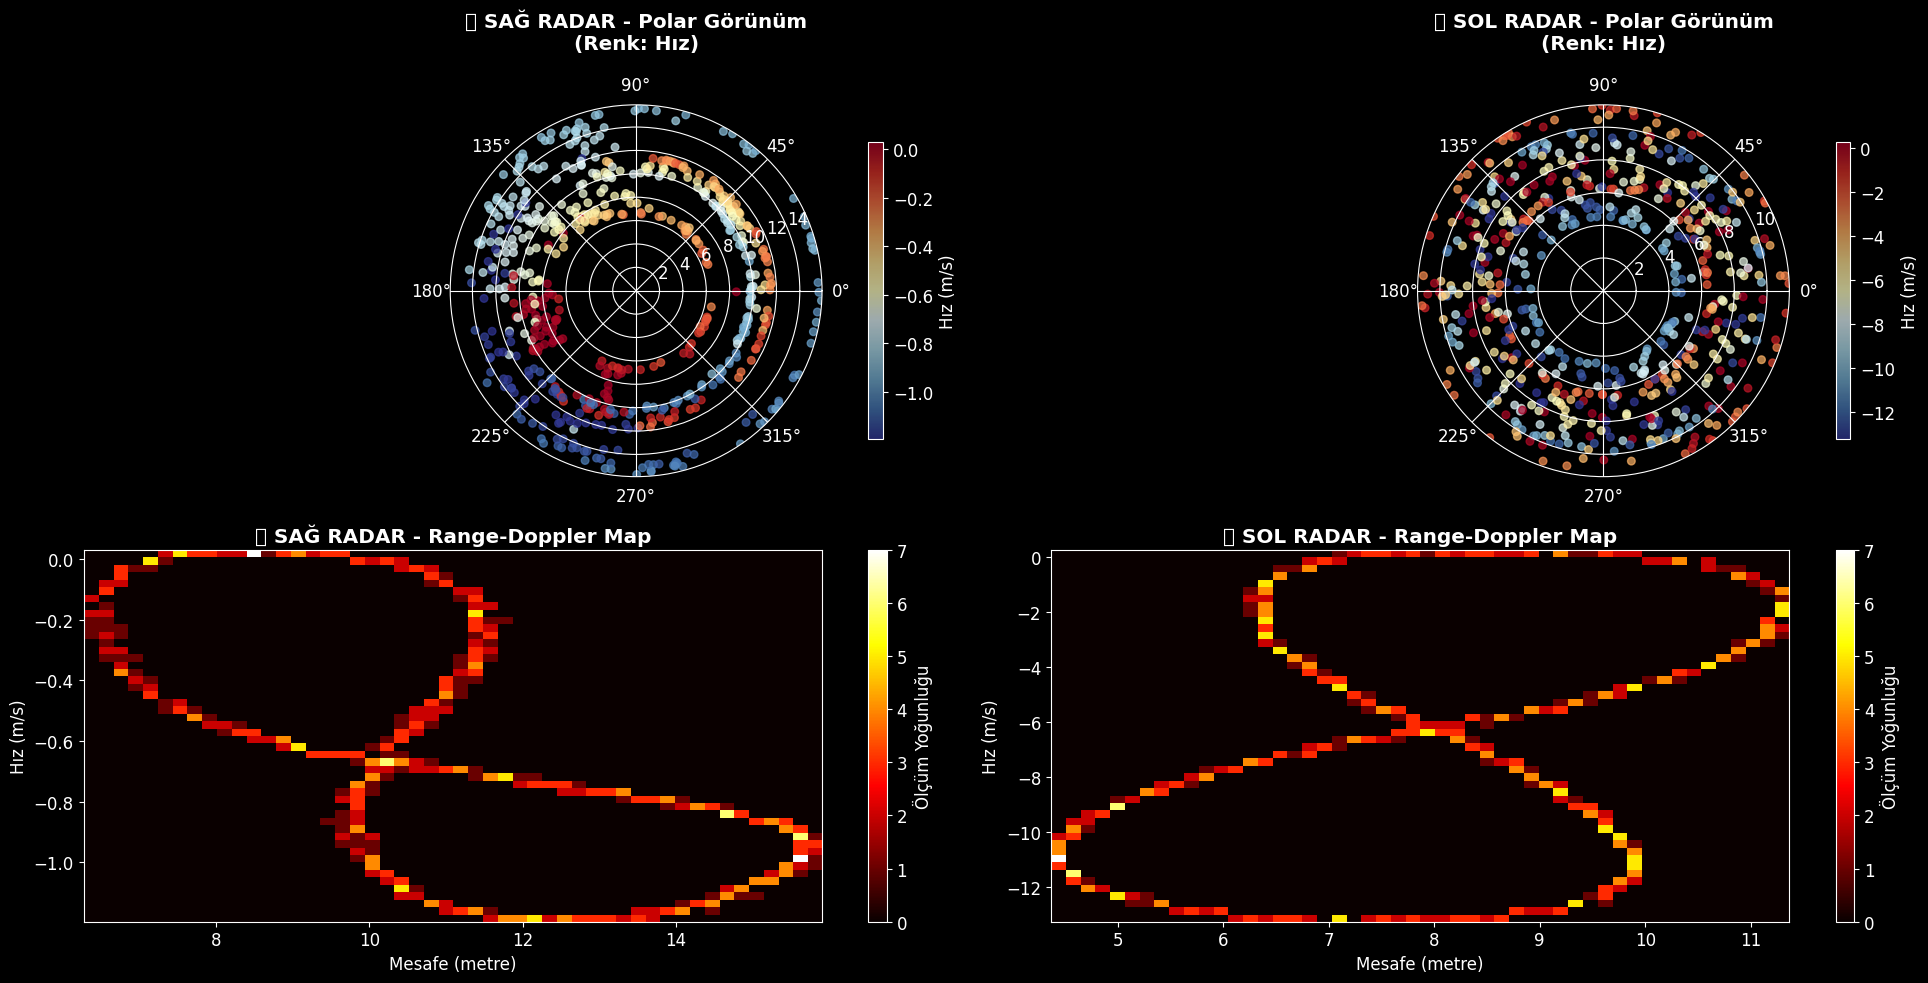

✅ Polar görünümler ve Range-Doppler haritaları tamamlandı!


In [9]:
# 🎯 Radar'a Özel Görselleştirmeler

print("🛡️ Radar spesifik görselleştirmeler oluşturuluyor...\n")

# 1. POLAR PLOT - Radar Tarama Görünümü
fig = plt.figure(figsize=(20, 10))

# Sağ radar polar plot
ax1 = plt.subplot(2, 2, 1, projection='polar')
scatter1 = ax1.scatter(right_sensor['raw_angle'], right_sensor['raw_range'], 
                      c=right_sensor['raw_velocity'], s=30, alpha=0.7, cmap='RdYlBu_r')
ax1.set_title('🎯 SAĞ RADAR - Polar Görünüm\n(Renk: Hız)', fontweight='bold', pad=20)
ax1.set_ylim(0, right_sensor['raw_range'].max())
plt.colorbar(scatter1, ax=ax1, label='Hız (m/s)', shrink=0.8)

# Sol radar polar plot  
ax2 = plt.subplot(2, 2, 2, projection='polar')
scatter2 = ax2.scatter(left_sensor['raw_angle'], left_sensor['raw_range'], 
                      c=left_sensor['raw_velocity'], s=30, alpha=0.7, cmap='RdYlBu_r')
ax2.set_title('🎯 SOL RADAR - Polar Görünüm\n(Renk: Hız)', fontweight='bold', pad=20)
ax2.set_ylim(0, left_sensor['raw_range'].max())
plt.colorbar(scatter2, ax=ax2, label='Hız (m/s)', shrink=0.8)

# 2. Range-Doppler Haritası
ax3 = plt.subplot(2, 2, 3)
# Sağ radar için 2D histogram
hist_r, xedges_r, yedges_r = np.histogram2d(right_sensor['raw_range'], 
                                           right_sensor['raw_velocity'], bins=50)
im1 = ax3.imshow(hist_r.T, origin='lower', aspect='auto', cmap='hot',
                extent=[xedges_r[0], xedges_r[-1], yedges_r[0], yedges_r[-1]])
ax3.set_title('🔥 SAĞ RADAR - Range-Doppler Map', fontweight='bold')
ax3.set_xlabel('Mesafe (metre)')
ax3.set_ylabel('Hız (m/s)')
plt.colorbar(im1, ax=ax3, label='Ölçüm Yoğunluğu')

ax4 = plt.subplot(2, 2, 4)
# Sol radar için 2D histogram
hist_l, xedges_l, yedges_l = np.histogram2d(left_sensor['raw_range'], 
                                           left_sensor['raw_velocity'], bins=50)
im2 = ax4.imshow(hist_l.T, origin='lower', aspect='auto', cmap='hot',
                extent=[xedges_l[0], xedges_l[-1], yedges_l[0], yedges_l[-1]])
ax4.set_title('🔥 SOL RADAR - Range-Doppler Map', fontweight='bold')
ax4.set_xlabel('Mesafe (metre)')
ax4.set_ylabel('Hız (m/s)')
plt.colorbar(im2, ax=ax4, label='Ölçüm Yoğunluğu')

plt.tight_layout()
plt.show()

print("✅ Polar görünümler ve Range-Doppler haritaları tamamlandı!")


🌍 3D ve interaktif görselleştirmeler oluşturuluyor...



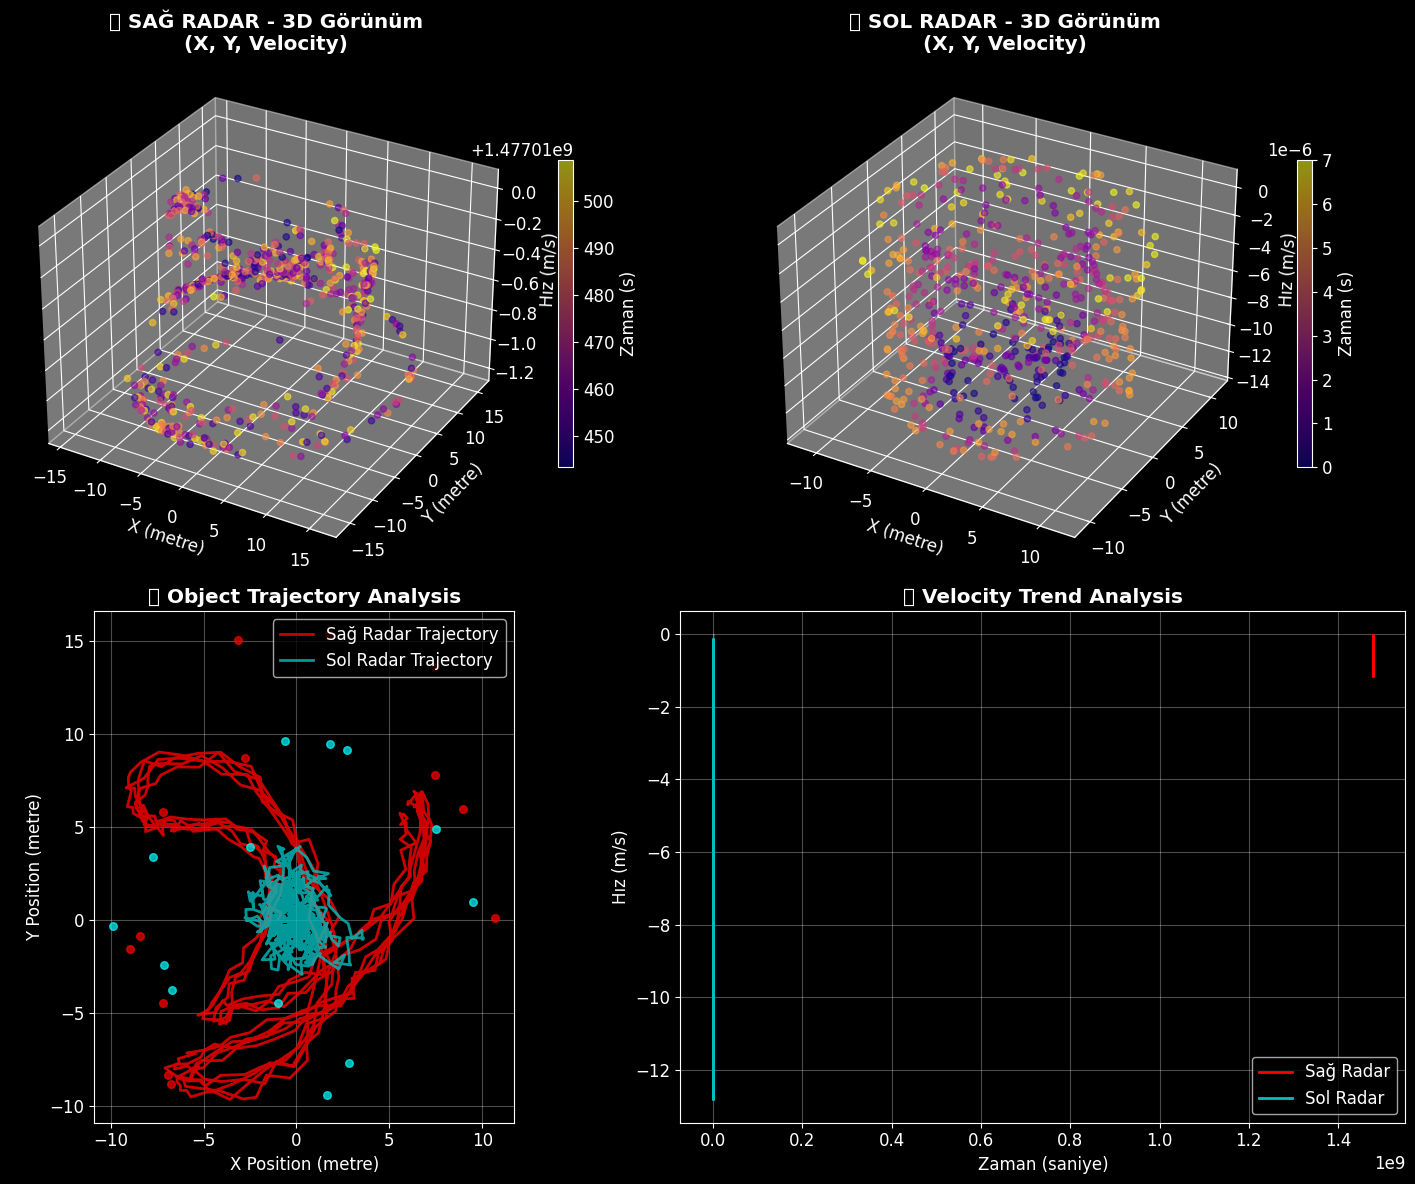

✅ 3D görselleştirmeler ve trajectory analizi tamamlandı!


In [10]:
# 🌐 3D ve İnteraktif Görselleştirmeler

print("🌍 3D ve interaktif görselleştirmeler oluşturuluyor...\n")

# 1. 3D Scatter Plot
fig = plt.figure(figsize=(15, 12))

# 3D plot için Kartezyen koordinatlara çevirme
def polar_to_cartesian(range_data, angle_data):
    x = range_data * np.cos(angle_data)
    y = range_data * np.sin(angle_data)
    return x, y

# Sağ radar koordinatları
x_right, y_right = polar_to_cartesian(right_sensor['raw_range'], right_sensor['raw_angle'])
# Sol radar koordinatları  
x_left, y_left = polar_to_cartesian(left_sensor['raw_range'], left_sensor['raw_angle'])

# 3D Scatter
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
scatter_3d_r = ax1.scatter(x_right, y_right, right_sensor['raw_velocity'], 
                          c=right_sensor['time_relative'], cmap='plasma', alpha=0.6, s=20)
ax1.set_title('🌐 SAĞ RADAR - 3D Görünüm\n(X, Y, Velocity)', fontweight='bold')
ax1.set_xlabel('X (metre)')
ax1.set_ylabel('Y (metre)')
ax1.set_zlabel('Hız (m/s)')
plt.colorbar(scatter_3d_r, ax=ax1, label='Zaman (s)', shrink=0.6)

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
scatter_3d_l = ax2.scatter(x_left, y_left, left_sensor['raw_velocity'], 
                          c=left_sensor['time_relative'], cmap='plasma', alpha=0.6, s=20)
ax2.set_title('🌐 SOL RADAR - 3D Görünüm\n(X, Y, Velocity)', fontweight='bold')
ax2.set_xlabel('X (metre)')
ax2.set_ylabel('Y (metre)')  
ax2.set_zlabel('Hız (m/s)')
plt.colorbar(scatter_3d_l, ax=ax2, label='Zaman (s)', shrink=0.6)

# 2. Trajectory Analysis
ax3 = fig.add_subplot(2, 2, 3)
# Moving average for smooth trajectory
window_size = 20
x_right_smooth = pd.Series(x_right).rolling(window=window_size, center=True).mean()
y_right_smooth = pd.Series(y_right).rolling(window=window_size, center=True).mean()
x_left_smooth = pd.Series(x_left).rolling(window=window_size, center=True).mean()
y_left_smooth = pd.Series(y_left).rolling(window=window_size, center=True).mean()

ax3.plot(x_right_smooth, y_right_smooth, 'r-', alpha=0.8, linewidth=2, label='Sağ Radar Trajectory')
ax3.plot(x_left_smooth, y_left_smooth, 'c-', alpha=0.8, linewidth=2, label='Sol Radar Trajectory')
ax3.scatter(x_right[::50], y_right[::50], c='red', s=30, alpha=0.7, zorder=5)
ax3.scatter(x_left[::50], y_left[::50], c='cyan', s=30, alpha=0.7, zorder=5)
ax3.set_title('🛣️ Object Trajectory Analysis', fontweight='bold')
ax3.set_xlabel('X Position (metre)')
ax3.set_ylabel('Y Position (metre)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

# 3. Velocity vs Time Analysis
ax4 = fig.add_subplot(2, 2, 4)
# Moving average for velocity
vel_right_smooth = pd.Series(right_sensor['raw_velocity']).rolling(window=window_size, center=True).mean()
vel_left_smooth = pd.Series(left_sensor['raw_velocity']).rolling(window=window_size, center=True).mean()

ax4.plot(right_sensor['time_relative'], vel_right_smooth, 'r-', linewidth=2, label='Sağ Radar')
ax4.plot(left_sensor['time_relative'], vel_left_smooth, 'c-', linewidth=2, label='Sol Radar')
ax4.fill_between(right_sensor['time_relative'], vel_right_smooth, alpha=0.3, color='red')
ax4.fill_between(left_sensor['time_relative'], vel_left_smooth, alpha=0.3, color='cyan')
ax4.set_title('📈 Velocity Trend Analysis', fontweight='bold')
ax4.set_xlabel('Zaman (saniye)')
ax4.set_ylabel('Hız (m/s)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 3D görselleştirmeler ve trajectory analizi tamamlandı!")


🎯 Object detection algoritmaları çalışıyor...

📊 Sağ Radar özellik matrisi: (612, 6)
📊 Sol Radar özellik matrisi: (612, 6)

🔍 DBSCAN ile obje gruplandırma...
  🎯 Sağ: 2 obje grubu, 85 gürültü noktası
  🎯 Sol: 6 obje grubu, 300 gürültü noktası


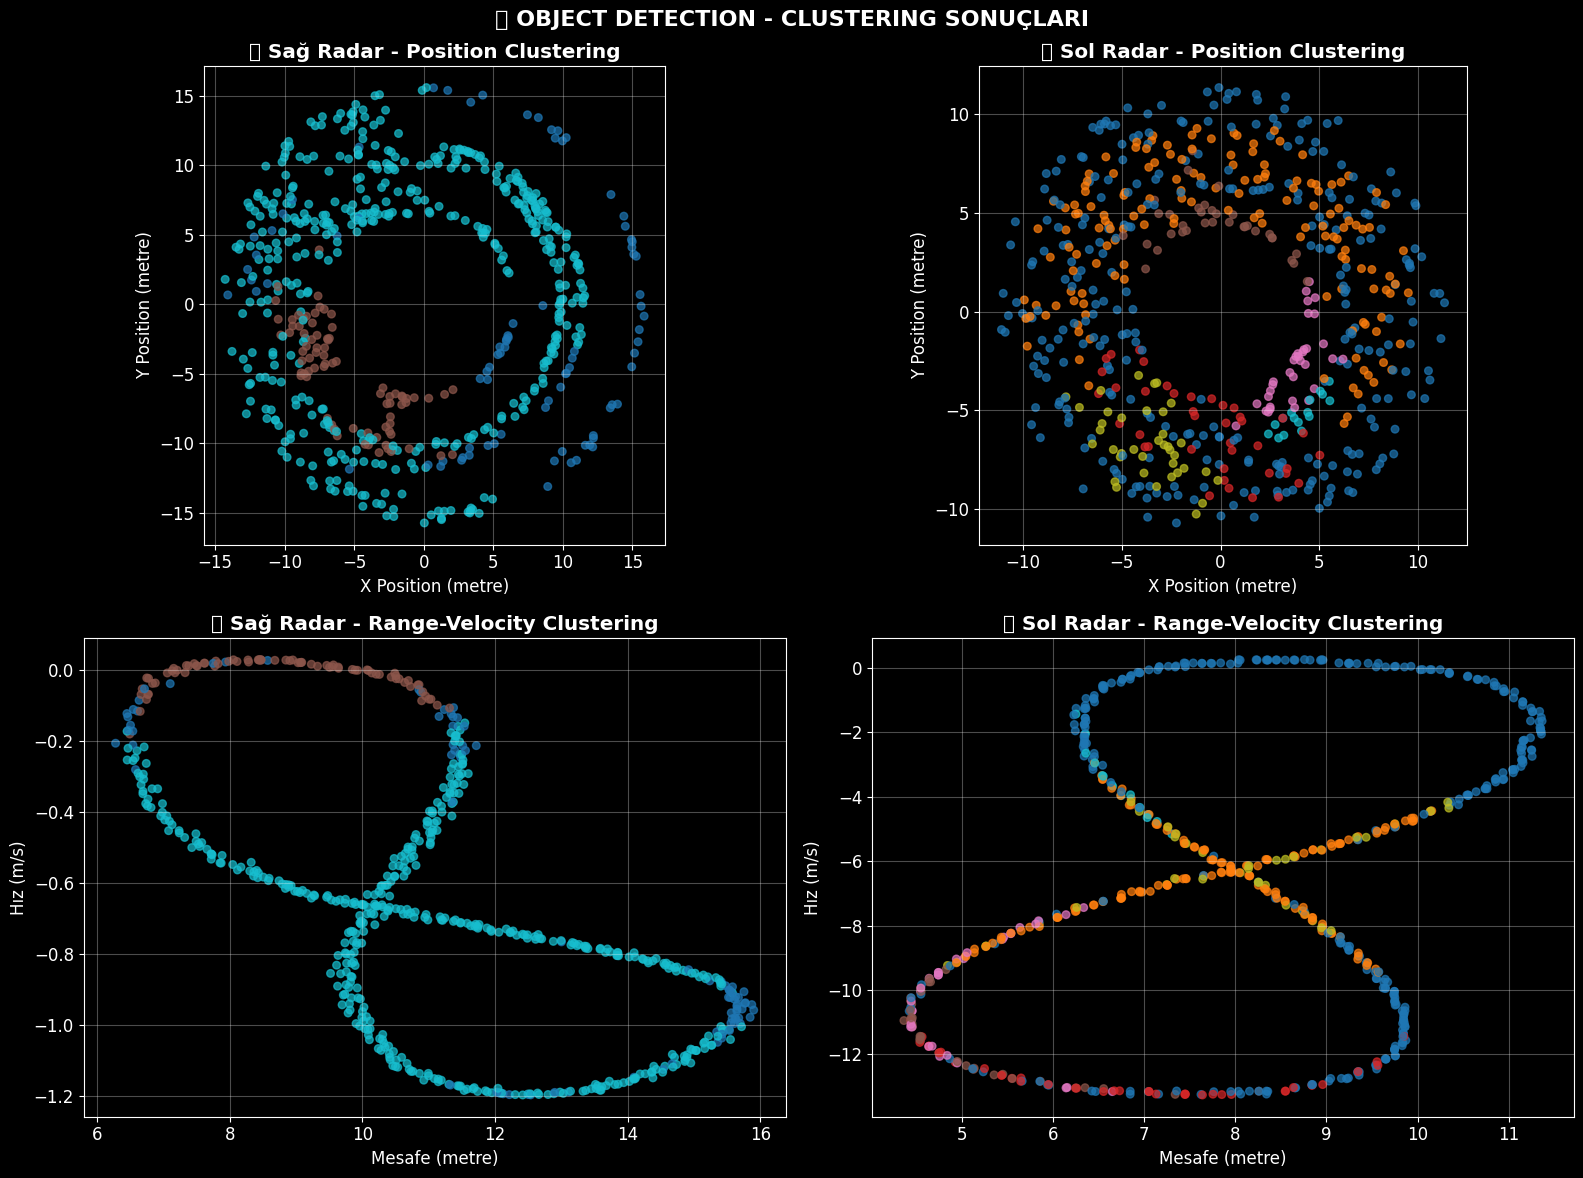

✅ Clustering analizi tamamlandı!


In [11]:
# 🤖 Object Detection ve Clustering Analizi

print("🎯 Object detection algoritmaları çalışıyor...\n")

# Veri hazırlığı - özellik matrisi oluşturma
def prepare_features(sensor_data, sensor_name):
    """Radar verisi için özellik matrisi hazırlar"""
    # Kartezyen koordinatlara çevirme
    x, y = polar_to_cartesian(sensor_data['raw_range'], sensor_data['raw_angle'])
    
    features = pd.DataFrame({
        'x_position': x,
        'y_position': y,
        'range': sensor_data['raw_range'].values,
        'velocity': sensor_data['raw_velocity'].values,
        'angle': sensor_data['raw_angle'].values,
        'time': sensor_data['time_relative'].values
    })
    
    print(f"📊 {sensor_name} özellik matrisi: {features.shape}")
    return features

# Her iki sensör için özellik matrisi
features_right = prepare_features(right_sensor, "Sağ Radar")
features_left = prepare_features(left_sensor, "Sol Radar")

# 1. DBSCAN Clustering - Obje Gruplandırma
print("\n🔍 DBSCAN ile obje gruplandırma...")

def apply_dbscan_clustering(features, sensor_name, eps=1.0, min_samples=10):
    """DBSCAN clustering uygula"""
    # Özellik normalizasyonu
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[['x_position', 'y_position', 'velocity']])
    
    # DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(features_scaled)
    
    features[f'{sensor_name}_cluster'] = clusters
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    
    print(f"  🎯 {sensor_name}: {n_clusters} obje grubu, {n_noise} gürültü noktası")
    
    return features, clusters

# DBSCAN uygulama
features_right, clusters_right = apply_dbscan_clustering(features_right, "Sağ", eps=0.5, min_samples=15)
features_left, clusters_left = apply_dbscan_clustering(features_left, "Sol", eps=0.5, min_samples=15)

# 2. Clustering Sonuçlarını Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🤖 OBJECT DETECTION - CLUSTERING SONUÇLARI', fontsize=16, fontweight='bold')

# Sağ radar - pozisyon clustering
scatter1 = axes[0,0].scatter(features_right['x_position'], features_right['y_position'], 
                           c=clusters_right, cmap='tab10', alpha=0.7, s=30)
axes[0,0].set_title('🎯 Sağ Radar - Position Clustering', fontweight='bold')
axes[0,0].set_xlabel('X Position (metre)')
axes[0,0].set_ylabel('Y Position (metre)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_aspect('equal')

# Sol radar - pozisyon clustering
scatter2 = axes[0,1].scatter(features_left['x_position'], features_left['y_position'], 
                           c=clusters_left, cmap='tab10', alpha=0.7, s=30)
axes[0,1].set_title('🎯 Sol Radar - Position Clustering', fontweight='bold')
axes[0,1].set_xlabel('X Position (metre)')
axes[0,1].set_ylabel('Y Position (metre)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_aspect('equal')

# Sağ radar - range-velocity clustering
axes[1,0].scatter(features_right['range'], features_right['velocity'], 
                c=clusters_right, cmap='tab10', alpha=0.7, s=30)
axes[1,0].set_title('📊 Sağ Radar - Range-Velocity Clustering', fontweight='bold')
axes[1,0].set_xlabel('Mesafe (metre)')
axes[1,0].set_ylabel('Hız (m/s)')
axes[1,0].grid(True, alpha=0.3)

# Sol radar - range-velocity clustering
axes[1,1].scatter(features_left['range'], features_left['velocity'], 
                c=clusters_left, cmap='tab10', alpha=0.7, s=30)
axes[1,1].set_title('📊 Sol Radar - Range-Velocity Clustering', fontweight='bold')
axes[1,1].set_xlabel('Mesafe (metre)')
axes[1,1].set_ylabel('Hız (m/s)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Clustering analizi tamamlandı!")


🚀 Object tracking ve detection algoritmaları...


🎯 Sağ Radar - Tespit Edilen Objeler:
  🏢 Statik Obje: Mesafe=8.8m, Hız=-0.01m/s, Süre=54.2s
  🚙 Uzaklaşan Araç: Mesafe=11.2m, Hız=-0.74m/s, Süre=64.0s

🎯 Sol Radar - Tespit Edilen Objeler:
  🚙 Uzaklaşan Araç: Mesafe=7.8m, Hız=-6.44m/s, Süre=0.0s
  🚙 Uzaklaşan Araç: Mesafe=6.9m, Hız=-12.68m/s, Süre=0.0s
  🚙 Uzaklaşan Araç: Mesafe=5.1m, Hız=-11.50m/s, Süre=0.0s
  🚙 Uzaklaşan Araç: Mesafe=5.1m, Hız=-10.06m/s, Süre=0.0s
  🚙 Uzaklaşan Araç: Mesafe=7.9m, Hız=-6.40m/s, Süre=0.0s
  🚙 Uzaklaşan Araç: Mesafe=6.7m, Hız=-3.63m/s, Süre=0.0s

🔄 Real-time detection simulasyonu...

✅ Sağ radar: 23 detection olayı
✅ Sol radar: 23 detection olayı


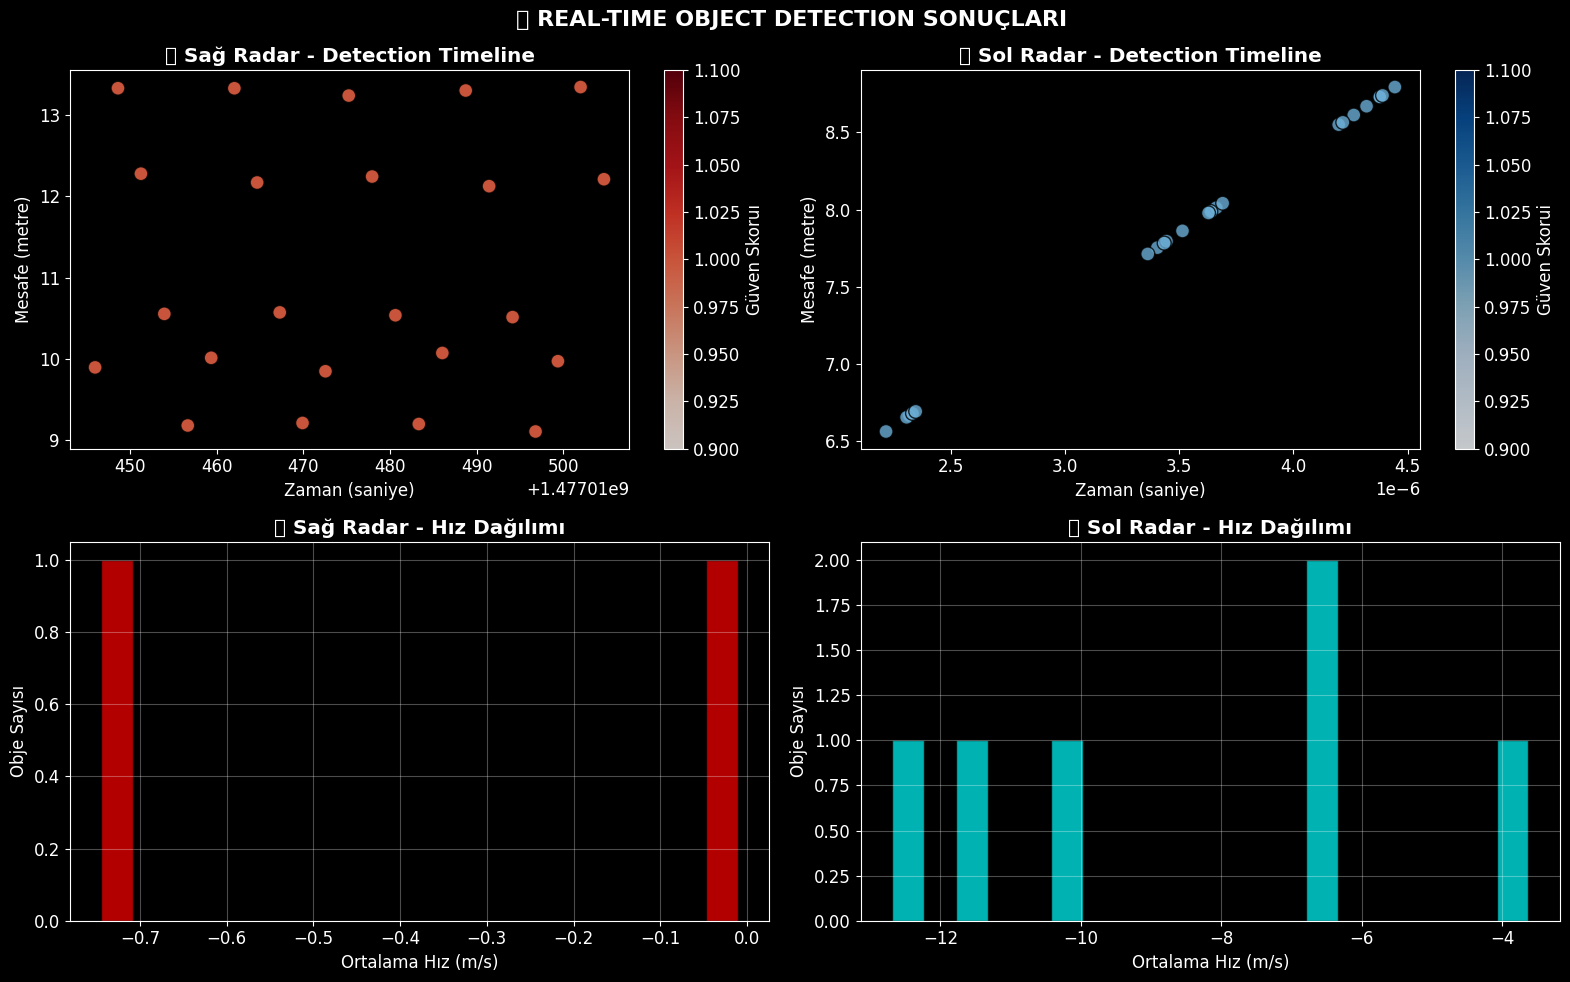


🎉 RADAR VERİSİ ANALİZİ TAMAMLANDI!
📊 Veri analizi, görselleştirme ve object detection başarıyla gerçekleştirildi.
🎯 Clustering, tracking ve real-time detection algoritmaları uygulandı.


In [12]:
# 🚀 Object Tracking ve Real-Time Detection

print("🚀 Object tracking ve detection algoritmaları...\n")

# 1. Obje Özelliklerini Analiz Et
def analyze_detected_objects(features, clusters, sensor_name):
    """Tespit edilen objelerin özelliklerini analiz et"""
    unique_clusters = set(clusters)
    if -1 in unique_clusters:
        unique_clusters.remove(-1)  # Gürültü noktalarını hariç tut
    
    object_stats = []
    
    for cluster_id in unique_clusters:
        cluster_mask = clusters == cluster_id
        cluster_data = features[cluster_mask]
        
        if len(cluster_data) < 5:  # Çok küçük grupları hariç tut
            continue
            
        stats = {
            'cluster_id': cluster_id,
            'n_points': len(cluster_data),
            'avg_range': cluster_data['range'].mean(),
            'avg_velocity': cluster_data['velocity'].mean(),
            'avg_x': cluster_data['x_position'].mean(),
            'avg_y': cluster_data['y_position'].mean(),
            'range_std': cluster_data['range'].std(),
            'velocity_std': cluster_data['velocity'].std(),
            'duration': cluster_data['time'].max() - cluster_data['time'].min()
        }
        
        # Obje türü tahmini
        if abs(stats['avg_velocity']) < 0.1:
            object_type = "🏢 Statik Obje"
        elif stats['avg_velocity'] > 0.5:
            object_type = "🚗 Yaklaşan Araç"
        elif stats['avg_velocity'] < -0.5:
            object_type = "🚙 Uzaklaşan Araç"
        else:
            object_type = "🚶 Yavaş Obje"
            
        stats['object_type'] = object_type
        object_stats.append(stats)
    
    print(f"\n🎯 {sensor_name} - Tespit Edilen Objeler:")
    for obj in object_stats:
        print(f"  {obj['object_type']}: Mesafe={obj['avg_range']:.1f}m, Hız={obj['avg_velocity']:.2f}m/s, Süre={obj['duration']:.1f}s")
    
    return object_stats

# Obje analizleri
objects_right = analyze_detected_objects(features_right, clusters_right, "Sağ Radar")
objects_left = analyze_detected_objects(features_left, clusters_left, "Sol Radar")

# 2. Real-Time Detection Simulasyonu
print(f"\n🔄 Real-time detection simulasyonu...\n")

def simulate_realtime_detection(sensor_data, window_size=50):
    """Gerçek zamanlı detection simülasyonu"""
    detections = []
    
    for i in range(0, len(sensor_data) - window_size, window_size//2):
        window_data = sensor_data.iloc[i:i+window_size]
        
        # Bu pencerede obje var mı?
        range_change = window_data['raw_range'].max() - window_data['raw_range'].min()
        velocity_avg = window_data['raw_velocity'].mean()
        
        if range_change > 1.0 or abs(velocity_avg) > 0.3:  # Eşik değerleri
            detection = {
                'time': window_data['time_relative'].mean(),
                'range': window_data['raw_range'].mean(),
                'velocity': velocity_avg,
                'confidence': min(1.0, (range_change + abs(velocity_avg)) / 2.0)
            }
            detections.append(detection)
    
    return detections

# Simülasyon çalıştır
detections_right = simulate_realtime_detection(right_sensor)
detections_left = simulate_realtime_detection(left_sensor)

print(f"✅ Sağ radar: {len(detections_right)} detection olayı")
print(f"✅ Sol radar: {len(detections_left)} detection olayı")

# 3. Detection Sonuçlarını Görselleştir
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('🚀 REAL-TIME OBJECT DETECTION SONUÇLARI', fontsize=16, fontweight='bold')

# Detection timeline - Sağ radar
if detections_right:
    det_times_r = [d['time'] for d in detections_right]
    det_ranges_r = [d['range'] for d in detections_right]
    det_confidences_r = [d['confidence'] for d in detections_right]
    
    scatter1 = axes[0,0].scatter(det_times_r, det_ranges_r, c=det_confidences_r, 
                               cmap='Reds', s=100, alpha=0.8, edgecolors='black')
    axes[0,0].set_title('🎯 Sağ Radar - Detection Timeline', fontweight='bold')
    axes[0,0].set_xlabel('Zaman (saniye)')
    axes[0,0].set_ylabel('Mesafe (metre)')
    plt.colorbar(scatter1, ax=axes[0,0], label='Güven Skoruı')

# Detection timeline - Sol radar
if detections_left:
    det_times_l = [d['time'] for d in detections_left]
    det_ranges_l = [d['range'] for d in detections_left]
    det_confidences_l = [d['confidence'] for d in detections_left]
    
    scatter2 = axes[0,1].scatter(det_times_l, det_ranges_l, c=det_confidences_l, 
                               cmap='Blues', s=100, alpha=0.8, edgecolors='black')
    axes[0,1].set_title('🎯 Sol Radar - Detection Timeline', fontweight='bold')
    axes[0,1].set_xlabel('Zaman (saniye)')
    axes[0,1].set_ylabel('Mesafe (metre)')
    plt.colorbar(scatter2, ax=axes[0,1], label='Güven Skorui')

# Velocity distribution by object type
right_velocities = [obj['avg_velocity'] for obj in objects_right]
right_types = [obj['object_type'] for obj in objects_right]

if right_velocities:
    axes[1,0].hist(right_velocities, bins=20, alpha=0.7, color='red', edgecolor='black')
    axes[1,0].set_title('🚗 Sağ Radar - Hız Dağılımı', fontweight='bold')
    axes[1,0].set_xlabel('Ortalama Hız (m/s)')
    axes[1,0].set_ylabel('Obje Sayısı')
    axes[1,0].grid(True, alpha=0.3)

left_velocities = [obj['avg_velocity'] for obj in objects_left]
left_types = [obj['object_type'] for obj in objects_left]

if left_velocities:
    axes[1,1].hist(left_velocities, bins=20, alpha=0.7, color='cyan', edgecolor='black')
    axes[1,1].set_title('🚗 Sol Radar - Hız Dağılımı', fontweight='bold')
    axes[1,1].set_xlabel('Ortalama Hız (m/s)')
    axes[1,1].set_ylabel('Obje Sayısı')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎉 RADAR VERİSİ ANALİZİ TAMAMLANDI!")
print("📊 Veri analizi, görselleştirme ve object detection başarıyla gerçekleştirildi.")
print("🎯 Clustering, tracking ve real-time detection algoritmaları uygulandı.")
